# <span id="toc">  Esercizio 7 - Monte Carlo NVT </span>

- [Esercizio 7.1](#ex07_1)

- [Esercizio 7.2](#ex07_2)

- [Esercizio 7.3](#ex07_3)

- [Esercizio 7.4](#ex07_4)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Il metodo **Monte Carlo (MC)** consente di campionare l’ensemble canonico **NVT**, in cui il numero di particelle $N$, 
il volume $V$ e la temperatura $T$ sono fissati. In particolare la temperatura non nasce dalla dinamica del sistema 
ma è imposta dall’esterno e le configurazioni vengono estratte con probabilità proporzionale al peso di Boltzmann.  

A differenza della Molecular Dynamics (MD) già tattata nell'Esercizio 4, qui non si integrano le equazioni del moto: le configurazioni vengono generate tramite mosse casuali accettate o rifiutate con l’algoritmo di Metropolis, di conseguenza quantità cinematiche come velocità ed energia cinetica non sono definite.

## <span id="ex07_1">  Esercizio 7.1 </span>[^](#toc)

In un sistema Lennard–Jones, utilizzando le unità ridotte $m=\epsilon=\sigma=k_B=1$, l’energia potenziale per particella $U/N$ si calcola sommando su tutte le coppie di particelle entro il raggio di cut–off $r_{cut}$:

$$
\frac{U}{N} = \frac{4}{N} \sum_{i<j, \; r_{ij}<r_{cut}} 
\left( \frac{1}{r_{ij}^{12}} - \frac{1}{r_{ij}^6} \right)
$$

La pressione $P$ si ottiene dalla formula del viriale $\langle W \rangle$:

$$
P = \rho T + \frac{1}{3V} 
\Bigg\langle \sum_{i<j} 48 \left( \frac{1}{r_{ij}^{12}} - \tfrac{1}{2}\frac{1}{r_{ij}^6} \right) \Bigg\rangle
= \rho T + \frac{\langle W \rangle}{3V}
$$

Poiché nel codice si tronca il potenziale a $r_{cut}$, si perdono i contributi delle interazioni a lungo raggio. Per compensare si introducono le cosiddette "tail corrections", le cui formule sono rispettivamente:

Le formule analitiche sono:

$$ 
\frac{U_\text{tail}}{N} = \frac{8\pi \rho}{3}\left(\frac{1}{3r_{cut}^9} - \frac{1}{r_{cut}^3}\right) \qquad 
P_\text{tail} = \frac{16\pi \rho^2}{3}\left(\frac{2}{3r_{cut}^9} - \frac{1}{r_{cut}^3}\right)
$$

in modo che nelle simulazioni queste correzioni vengano sommate ai valori troncati indicati in precedenza.

## <span id="ex07_2">  Esercizio 7.2 </span>[^](#toc)

In questo esercizio l'obiettivo è quello di stimare quanto persistono le correlazioni tra configurazioni successive durante una simulazione, analizzando in particolare l’energia potenziale per particella $U/N$. Questo permette di capire quanto grandi devono essere i blocchi da usare nella tecnica di data blocking per ottenere campioni statisticamente indipendenti.

Per ogni simulazione ho considerato tre condizioni termodinamiche:

- **Fase liquida**: $T = 1.1, \; \rho = 0.8, \; r_{cut} = 2.5$  
- **Fase solida**: $T = 0.8, \; \rho = 1.1, \; r_{cut} = 2.2$  
- **Fase gassosa**: $T = 1.2, \; \rho = 0.05, \; r_{cut} = 5.0$

applicate ad un sistema di $N= 108$ particelle.

### Fase di equilibrazione

Come negli esercizi precedenti, anche in questo caso prima di procedere alla vera simulazione è necessario eseguire un'equilibrazione del sistema, inizialmente in uno stato ordinato.

Con il metodo MC la temperatura $T$ è fissa, quindi durante la simulazione il suo valore rimane costante rispetto a quello fornito in input. Per ciascuna delle fasi considerate è necessario impostare un'ampiezza del passo proposto per l'algoritmo di Metropolis tale da ottenere un'accettazione di circa il $50\%$.

```
4000          blocchi
1             step per blocco
1.2/1.1/0.8   temp gas/liq/sol
0.05/0.8/1.1  rho gas/liq/sol
5.0/2.5/2.2   r_cut gas/liq/sol
2.5/0.1/0.06  passo gas/liq/sol
```

Con il metodo MD, come visto nell'Esercizio 4, la temperatura non rimane costante durante la simulazione. È necessario quindi fornire in input un valore tale che, al termine della fase di equilibrazione, si sia raggiunta una $T$ simile a quella utilizzata nella corrispondente simulazione MC. Il passo di integrazione dell'algoritmo Verlet per l'aggiornamento delle posizioni delle particelle, è fissato a $\delta = 0.001$.
```
4000          blocchi
1             step per blocco
1.0/2.0/1.5   temp gas/liq/sol
0.05/0.8/1.1  rho gas/liq/sol
5.0/2.5/2.2   r_cut gas/liq/sol
```

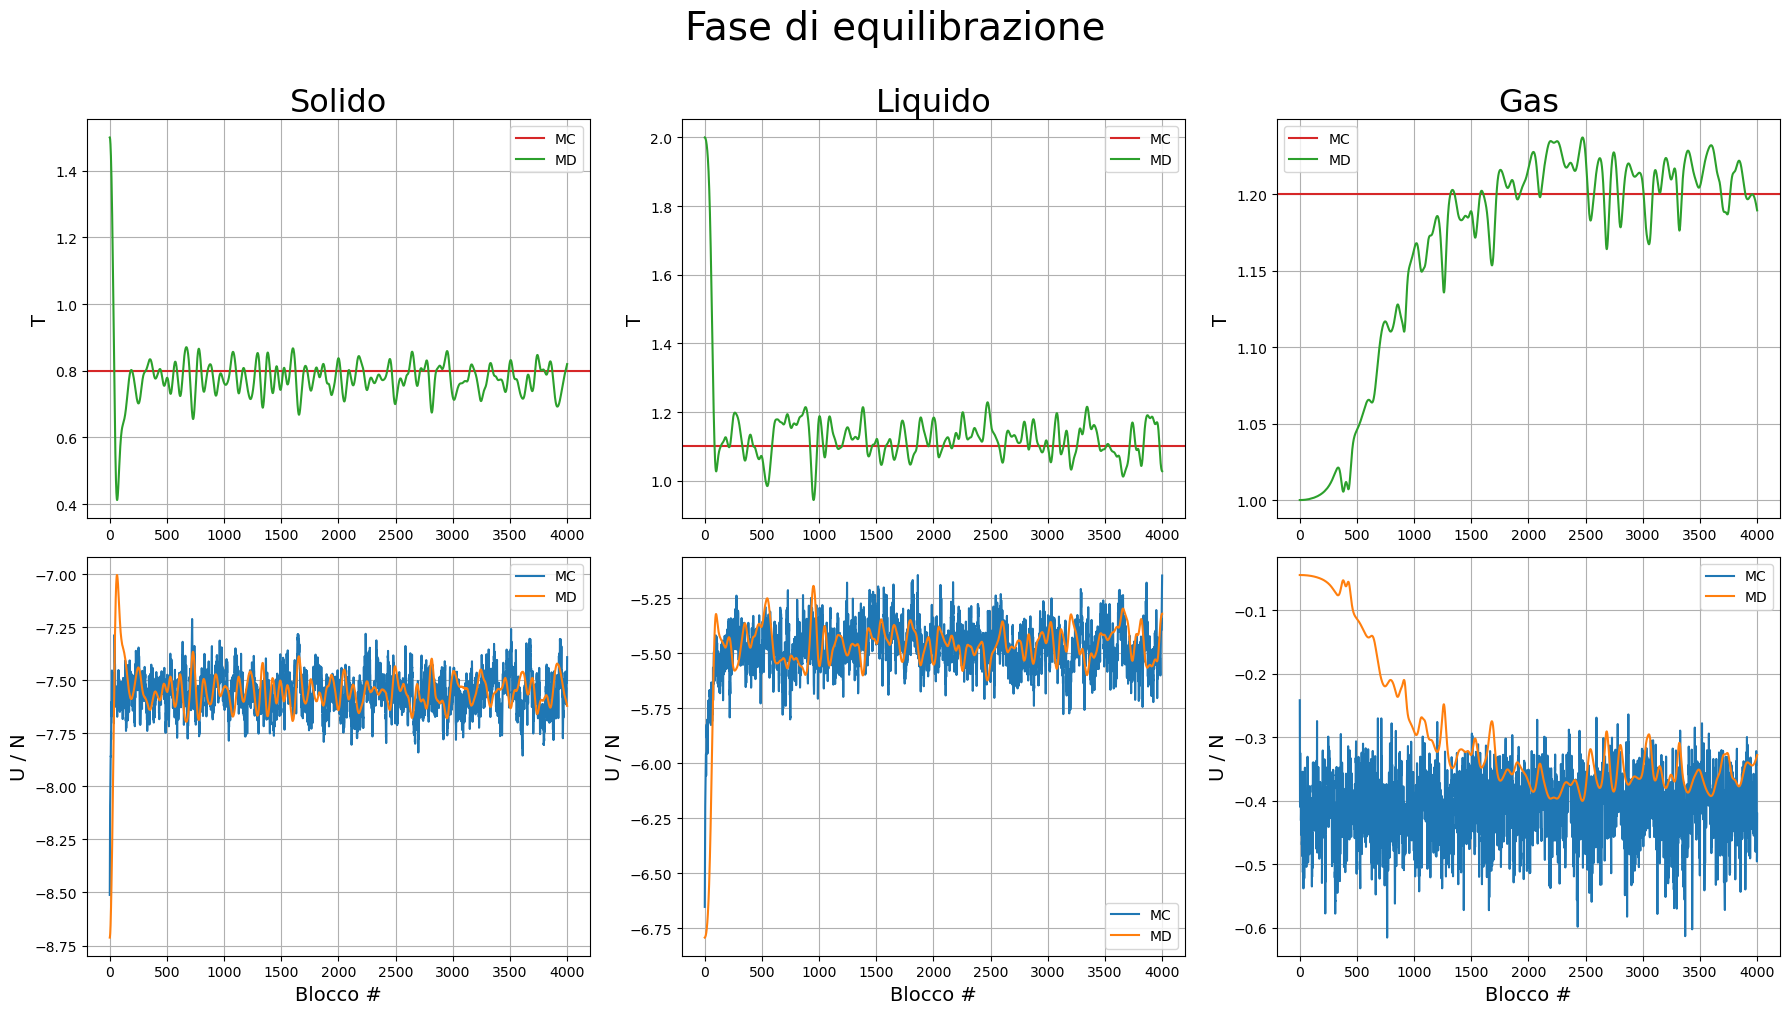

In [2]:
# Fase di equilibrazione
plt.figure(figsize=(18, 10))
plt.suptitle('Fase di equilibrazione', fontsize=28, y=1.01)

# Temperatura
# Solido
plt.subplot(2, 3, 1)
block, T_s = np.loadtxt('OUTPUT/equilibration/MD/solid/temperature.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.axhline(y=0.8, color='tab:red', label='MC')
plt.plot(block, T_s, color='tab:green', label='MD')
plt.ylabel('T', fontsize=14)
plt.title('Solido', fontsize=23)
plt.grid(True)
plt.legend()
# Liquido
plt.subplot(2, 3, 2)
block, T_l = np.loadtxt('OUTPUT/equilibration/MD/liquid/temperature.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.axhline(y=1.1, color='tab:red', label='MC')
plt.plot(block, T_l, color='tab:green', label='MD')
plt.ylabel('T', fontsize=14)
plt.title('Liquido', fontsize=23)
plt.grid(True)
plt.legend()
# Gas
plt.subplot(2, 3, 3)
block, T_g = np.loadtxt('OUTPUT/equilibration/MD/gas/temperature.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.axhline(y=1.2, color='tab:red', label='MC')
plt.plot(block, T_g, color='tab:green', label='MD')
plt.ylabel('T', fontsize=14)
plt.title('Gas', fontsize=23)
plt.grid(True)
plt.legend()

# Energia potenziale
# Solido
plt.subplot(2, 3, 4)
block, U_s_MC = np.loadtxt('OUTPUT/equilibration/MC/solid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_s_MD = np.loadtxt('OUTPUT/equilibration/MD/solid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.plot(block, U_s_MC, label='MC')
plt.plot(block, U_s_MD, label='MD')
plt.xlabel('Blocco #', fontsize=14)
plt.ylabel('U / N', fontsize=14)
plt.grid(True)
plt.legend()
# Liquido
plt.subplot(2, 3, 5)
block, U_l_MC = np.loadtxt('OUTPUT/equilibration/MC/liquid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_l_MD = np.loadtxt('OUTPUT/equilibration/MD/liquid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.plot(block, U_l_MC, label='MC')
plt.plot(block, U_l_MD, label='MD')
plt.xlabel('Blocco #', fontsize=14)
plt.ylabel('U / N', fontsize=14)
plt.grid(True)
plt.legend()
# Gas
plt.subplot(2, 3, 6)
block, U_g_MC = np.loadtxt('OUTPUT/equilibration/MC/gas/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_g_MD = np.loadtxt('OUTPUT/equilibration/MD/gas/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
plt.plot(block, U_g_MC, label='MC')
plt.plot(block, U_g_MD, label='MD')
plt.xlabel('Blocco #', fontsize=14)
plt.ylabel('U / N', fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


I grafici mostrano che entro $4000$ blocchi il sistema risulta equilibrato per ognuna delle fasi considerate.

Nel caso del gas l’equilibrazione in MD è molto più lenta rispetto a liquido e solido. Questo accade perché alla bassa densità le particelle interagiscono debolmente e gli urti sono rari, lo scambio di energia tra le particelle avviene quindi in modo molto meno efficiente.  

Di conseguenza la temperatura iniziale fornita al sistema impiega molto più tempo ad aggiustarsi fino al valore corretto, e anche l’energia potenziale per particella $U/N$ si stabilizza solo dopo un numero elevato di blocchi.  
Al contrario, nel liquido e solido gli urti frequenti favoriscono un’equilibrazione rapida.

Con il metodo MC invece questo problema non si presenta: la temperatura è fissata a priori dall’ensemble NVT, quindi le configurazioni campionate rispettano subito la distribuzione di Boltzmann e $U/N$ risulta stazionario fin dall’inizio della simulazione.

### Autocorrelazione

In questa parte ho ripetuto l'analisi sull’andamento dell’energia potenziale per particella $U/N$ durante simulazioni MC e MD, aumentando il numero di passi (blocchi da uno step ciascuno) a $M = 5 \times 10^5$e ripartendo dal sistema equilibrato tramite `restart`.   

Per ciascun caso è stata calcolata la funzione di autocorrelazione di $U/N$, con lo scopo di stimare il "tempo" di autocorrelazione $\tau$, cioè dopo quanti passi le misure possono essere considerate statisticamente indipendenti.
Questo è fondamentale per applicare correttamente la tecnica del data blocking, in cui la dimensione del blocco $L$ deve essere molto più grande di $\tau$.  

La funzione di autocorrelazione è stata calcolata a partire dai dati numerici, utilizzando la formula:

$$
\chi(\tau) = 
\frac{\frac{1}{M-\tau}\sum_{t=0}^{M-\tau} m(t)\,m(t+\tau) \;-\; 
\left(\frac{1}{M-\tau}\sum_{t=0}^{M-\tau} m(t)\right)
\left(\frac{1}{M-\tau}\sum_{t=0}^{M-\tau} m(t+\tau)\right)}
{\frac{1}{M}\sum_{t=0}^{M} m^2(t) \;-\;
\left(\frac{1}{M}\sum_{t=0}^{M} m(t)\right)^2 }
$$

dove $m(t)$ rappresenta il valore di $U/N$ al passo $t$.

Nel calcolo ho introdotto un parametro $\tau_{\text{max}}$, che rappresenta il massimo ritardo fino al quale viene valutata l’autocorrelazione. In particolare ho scelto $\tau_{\text{max}} = 200$ per MC e $\tau_{\text{max}} = 500$ per MD, così da osservare l’intero andamento della correlazione.

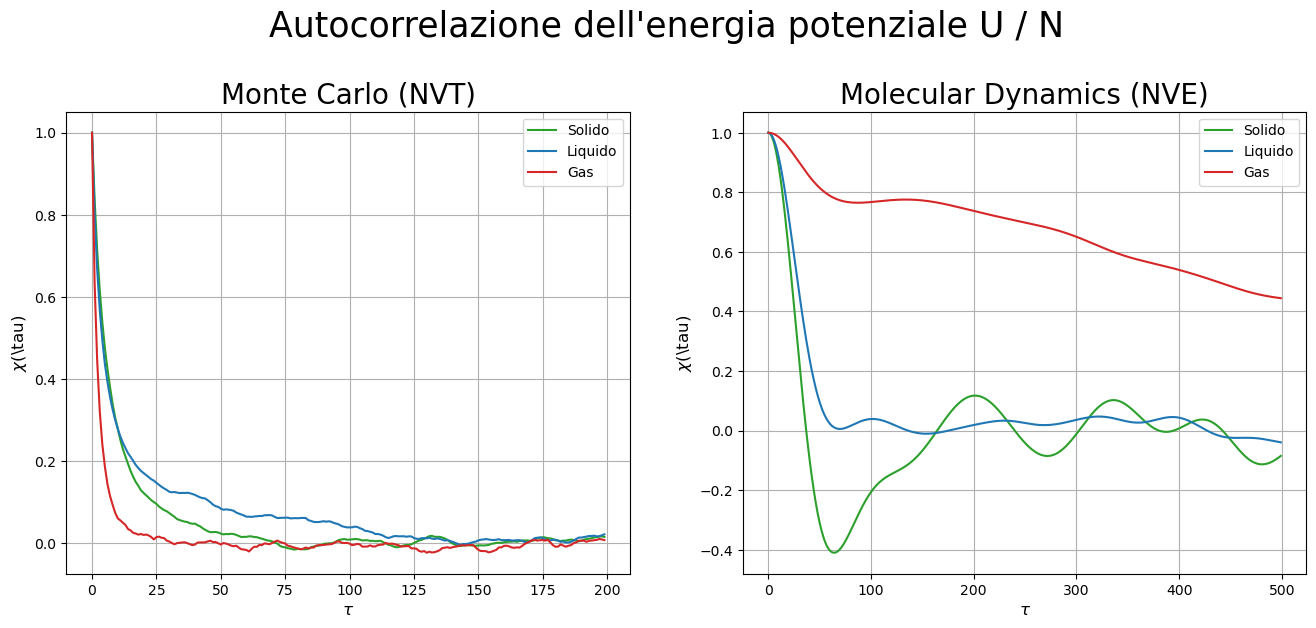

In [3]:
# Autocorrelazione
def autocorrelation(U, taumax):
    tmax = len(U)
    chi = []
    for tau in range(taumax):
        s1 = s2 = s3 = s4 = s5 = 0.0
        for tp in range(tmax - tau):
            s1 += U[tp] * U[tp + tau]
            s2 += U[tp]
            s3 += U[tp + tau]
        for tp in range(tmax):
            s4 += U[tp] * U[tp]
            s5 += U[tp]
        fatt = 1 / (tmax - tau)
        fatt2 = 1 / tmax
        num = fatt * s1 - fatt * s2 * fatt * s3
        den = fatt2 * s4 - (fatt2 * s5) ** 2
        chi.append(num / den)
    return chi

plt.figure(figsize=(16,6))
plt.suptitle("Autocorrelazione dell'energia potenziale U / N", fontsize=25, y=1.05)

block, U_s_MC = np.loadtxt('OUTPUT/autocorrelation/MC/solid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_s_MD = np.loadtxt('OUTPUT/autocorrelation/MD/solid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_l_MC = np.loadtxt('OUTPUT/autocorrelation/MC/liquid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_l_MD = np.loadtxt('OUTPUT/autocorrelation/MD/liquid/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_g_MC = np.loadtxt('OUTPUT/autocorrelation/MC/gas/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)
block, U_g_MD = np.loadtxt('OUTPUT/autocorrelation/MD/gas/potential_energy.dat', skiprows=1, usecols=(0,1), unpack=True)

U_MC = [U_s_MC, U_l_MC, U_g_MC]
U_MD = [U_s_MD, U_l_MD, U_g_MD]
labels = ['Solido', 'Liquido', 'Gas']
colors = ['tab:green', 'tab:blue', 'tab:red']

taumax_MC = 200
taumax_MD = 500

# MC
plt.subplot(1,2,1)
for i in range(3):
    chi_MC = autocorrelation(U_MC[i], taumax_MC)
    plt.plot(chi_MC, label=f'{labels[i]}', color=colors[i])
plt.xlabel('$\\tau$', fontsize = 12)
plt.ylabel('$\chi($\\tau$)$', fontsize = 12)
plt.title('Monte Carlo (NVT)', fontsize=20)
plt.grid(True)
plt.legend()

# MD
plt.subplot(1,2,2)
for i in range(3):
    chi_MD = autocorrelation(U_MD[i], taumax_MD)
    plt.plot(chi_MD, label=f'{labels[i]}', color=colors[i])
plt.xlabel('$\\tau$', fontsize = 12)
plt.ylabel('$\chi($\\tau$)$', fontsize = 12)
plt.title('Molecular Dynamics (NVE)', fontsize=20)
plt.grid(True)
plt.legend()

plt.show()

Con il metodo MC l’autocorrelazione decadone esponenzialmente verso zero in tutte le fasi, con un tempo caratteristico di un centinaio di passi.  

Con il metodo MD l’andamento è diverso: nel solido compaiono oscillazioni attorno a zero, nel liquido il decadimento è più graduale e presenta leggere oscillazioni residue, mentre nel gas la correlazione persiste molto più a lungo e non è completamente decaduta nemmeno per $\tau \approx 500$.  

In sintesi, MC fornisce campioni quasi indipendenti dopo pochi passi, mentre in MD la persistenza delle correlazioni dipende fortemente dallo stato del sistema.

### Incertezze con data blocking

Se i dati adiacenti sono correlati, l'incertezza statistica risulta sottostimata. 
La dimensione del singolo blocco quindi deve essere superiore alla distanza di autocorrelazione tra misure successive.

Ho applicato il data blocking ai precedenti dati, variando la dimensione del blocco tra $L = 10$ fino a $L = 5\times 10^3$, con step di $10$.
Per ogni configurazione ho rappresentato l’incertezza statistica sulla stima di $U/N$ in funzione di $L$, tramite la formula:

$$
\sigma_{\langle m\rangle}
= \sqrt{ \frac{1}{n-1} \left[
\frac{1}{n}\sum_{i=1}^{n} m_i^{\,2}
- \left( \frac{1}{n}\sum_{i=1}^{n} m_i \right)^{2}
\right] }
$$

dove $m_i$ è il valore medio di $U/N$ calcolato nel blocco $i$ e $n$ è il numero totale di blocchi.

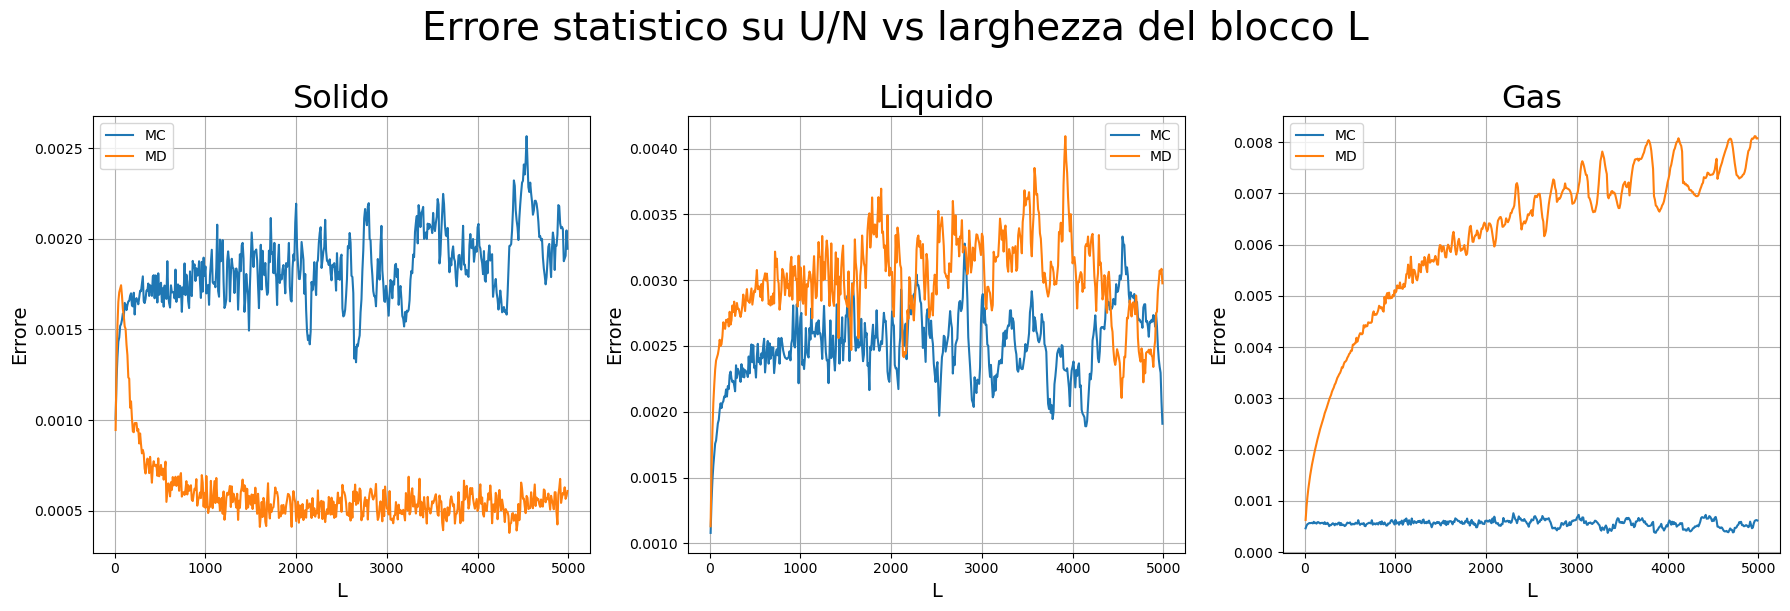

In [4]:
# Incertezze
def error(ave, ave2, n):
    if n == 0:
        return 0
    return np.sqrt((ave2 - ave**2) / n)

def data_blocking(x, N, L):
    mean = 0
    mean2 = 0
    err = 0
    for n in range(N):
        mean_block = 0
        for l in range(L):
            mean_block += x[l + n*L]
        mean_block /= L
        mean = (mean * n + mean_block) / (n+1)
        mean2 = (mean2 * n + mean_block**2) / (n+1)
        err = error(mean, mean2, n)
    return err

fig, axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("Errore statistico su U/N vs larghezza del blocco L", fontsize=28, y=1.01)

L_min = 10
L_max = 5000
step = 10

phase = ['Solido', 'Liquido', 'Gas']

for i in range(3):
    M = len(U_MC[i])
    x = []
    err_MC = []
    err_MD = []

    for L in range(L_min, L_max, step):
        N = int(M / L)
        err_MC.append(data_blocking(U_MC[i], N, L))
        err_MD.append(data_blocking(U_MD[i], N, L))
        x.append(L)

    # Plot
    axs[i].plot(x, err_MC, label='MC')
    axs[i].plot(x, err_MD, label='MD')
    axs[i].set_xlabel('L', fontsize=14)
    axs[i].set_ylabel('Errore', fontsize=14)
    axs[i].set_title(f'{phase[i]}', fontsize=23)
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

In generale si sserva che per $L$ piccoli l’errore è sottostimato a causa delle forti correlazioni tra campioni adiacenti.
All’aumentare di $L$ l’errore cresce fino a stabilizzarsi intorno alla reale incertezza statistica della stima, indicando la scelta di blocchi sufficientemente grandi. 

Nel solido l’errore converge rapidamente e rimane più basso in MD che in MC, mentre nel liquido i due metodi forniscono errori simili. 
Nel gas invece l’errore in MD cresce lentamente e raggiunge valori molto maggiori rispetto a MC: ciò riflette la lunga persistenza delle correlazioni osservata nella funzione di autocorrelazione, che richiede blocchi molto grandi per ottenere stime indipendenti.

In sintesi, l’analisi delle funzioni di autocorrelazione e delle incertezze ha permesso di validare il numero di passi indipendenti utilizzabili in ogni blocco, che nel caso di un sistema in fase liquida (che indagherò nei prossimi punti), deve essere superiore a $\approx 1000$.

## <span id="ex07_3">  Esercizio 7.3 </span>[^](#toc)

La funzione di distribuzione radiale $g(r)$ descrive la probabilità di trovare una particella 
a distanza $r$ da un’altra particella, con $r \in \left[ 0; L/2\right]$ dove $L$ è la larghezza del singolo blocco:

$$
g(r) = \frac{1}{\rho N \Delta V(r)} 
\Bigg\langle \sum_{i=1}^N \sum_{j>i} \delta(r-r_{ij}) \Bigg\rangle 
$$
dove $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$.

Questa distribuzione è stata stimata suddividendo l’intervallo in $100$ bin (quindi $dr = L/200$) 
e scorrendo tutte le coppie di particelle. Per ogni distanza calcolata ho incrementato di $2$ 
il contatore del bin corrispondente, costruendo così l’istogramma normalizzato.

## <span id="ex07_4">  Esercizio 7.4 </span>[^](#toc)

Considero ora un particolare sistema di particelle in fase liquida, ad esempio l'Argon, descritto dagli stessi parametri riporatati nel primo punto.

Eseguo una simulazione sia con il metodo MC che con MD, ripartendo dalle condizioni ottenute al termine della fase di equiliibrazione. L'obiettivo è quello di stimre i valori di energia potenziale $U/N$, pressione $P$ e funzione di distribuzione radiale $g(r)$ con entrambi i metodi.

Coerentemente con quanto trovato nelle sezioni precedenti, utilizzo i seguenti valori per il data blocking:

```
50    blocchi
2000  step per blocco
```

### Energia potenziale

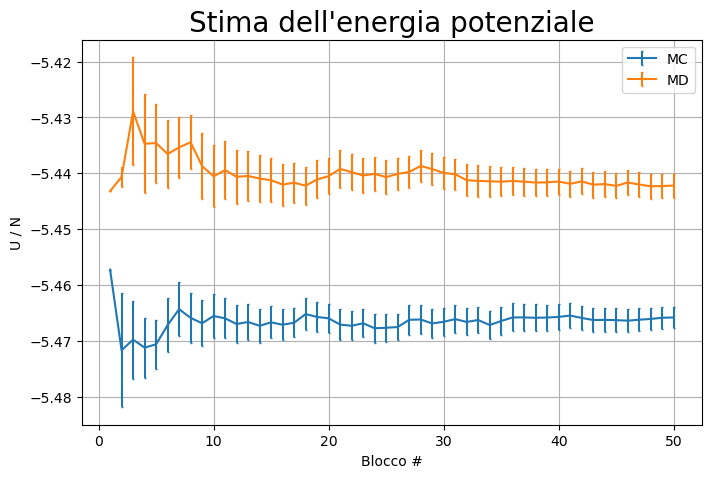

Valore medio finale di U/N per simulazione MC =  -5.46579
Incertezza =  0.00191048

Valore medio finale di U/N per simulazione MD =  -5.44218
Incertezza =  0.00214726


In [5]:
# Energia potenziale
plt.figure(figsize=(8,5))

block, U_A_MC, err_U_MC = np.loadtxt('OUTPUT/argon/MC/potential_energy.dat', skiprows=1, usecols=(0,2,3), unpack=True)
block, U_A_MD, err_U_MD = np.loadtxt('OUTPUT/argon/MD/potential_energy.dat', skiprows=1, usecols=(0,2,3), unpack=True)

plt.errorbar(block, U_A_MC, yerr=err_U_MC, capsize=1, label='MC')
plt.errorbar(block, U_A_MD, yerr=err_U_MD, capsize=1, label='MD')
plt.xlabel('Blocco #', fontsize=10)
plt.ylabel('U / N', fontsize=10)
plt.title("Stima dell'energia potenziale", fontsize=20)
plt.grid(True)
plt.legend()

plt.show()

print("Valore medio finale di U/N per simulazione MC = ", U_A_MC[-1])
print('Incertezza = ', err_U_MC[-1])
print()
print("Valore medio finale di U/N per simulazione MD = ", U_A_MD[-1])
print('Incertezza = ', err_U_MD[-1])

### Pressione

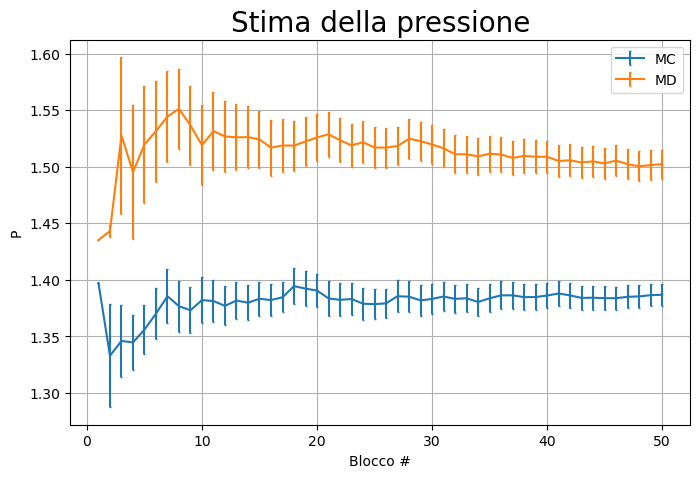

Valore medio finale di P per simulazione MC =  1.3868
Incertezza =  0.00958259

Valore medio finale di P per simulazione MD =  1.50224
Incertezza =  0.012831


In [6]:
# Pressione
plt.figure(figsize=(8,5))

block, P_A_MC, err_P_MC = np.loadtxt('OUTPUT/argon/MC/pressure.dat', skiprows=1, usecols=(0,2,3), unpack=True)
block, P_A_MD, err_P_MD = np.loadtxt('OUTPUT/argon/MD/pressure.dat', skiprows=1, usecols=(0,2,3), unpack=True)

plt.errorbar(block, P_A_MC, yerr=err_P_MC, capsize=1, label='MC')
plt.errorbar(block, P_A_MD, yerr=err_P_MD, capsize=1, label='MD')
plt.xlabel('Blocco #', fontsize=10)
plt.ylabel('P', fontsize=10)
plt.title("Stima della pressione", fontsize=20)
plt.grid(True)
plt.legend()

plt.show()

print("Valore medio finale di P per simulazione MC = ", P_A_MC[-1])
print('Incertezza = ', err_P_MC[-1])
print()
print("Valore medio finale di P per simulazione MD = ", P_A_MD[-1])
print('Incertezza = ', err_P_MD[-1])

Dai grafici di $U/N$ e $P$ si osserva che le stime ottenute con MC e MD forniscono valori dello stesso ordine di grandezza, ma non sovrapponibili entro le barre di errore. 

Le differenze vanno quindi oltre le sole fluttuazioni statistiche e possono avere diverse possibili cause: la natura differente delle due simulazioni, che campionano ensemble diversi e richiedono quindi tempi di equilibrazione differenti; oppure aspetti numerici come la lunghezza della simulazione o l’ampiezza dei blocchi, che possono influenzare le stime finali.

### Funzione di distribuzione radiale

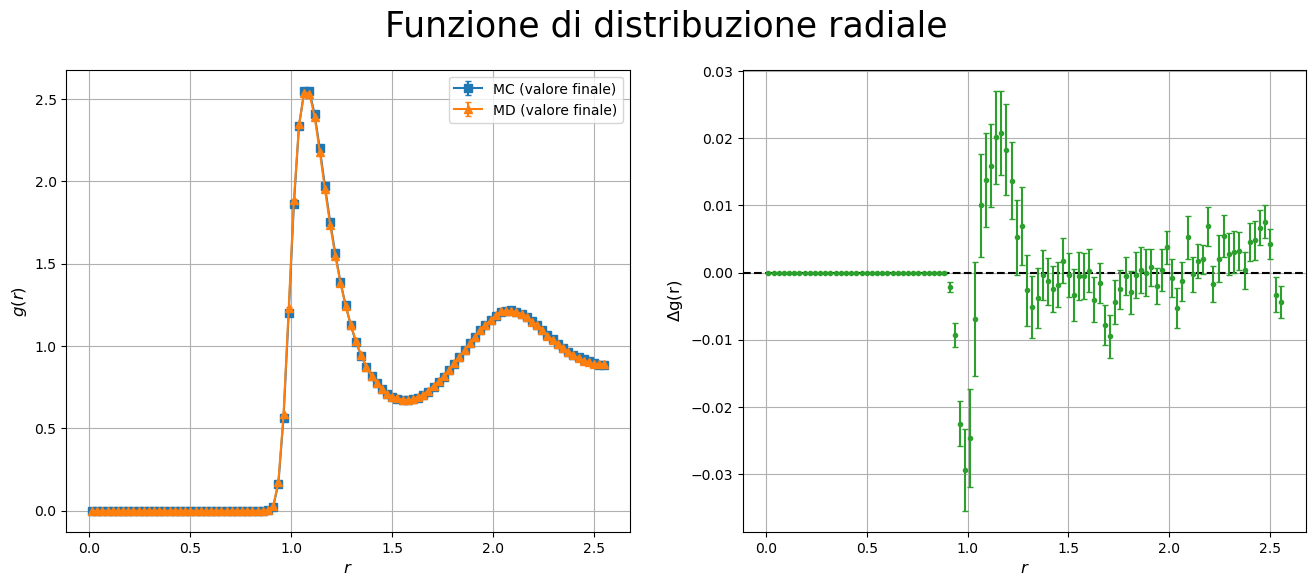

In [8]:
# Funzione di distribuzione radiale
r_MC, g_MC, err_MC = np.loadtxt('OUTPUT/argon/MC/gofr.dat', skiprows=1, unpack=True)
r_MD, g_MD, err_MD = np.loadtxt('OUTPUT/argon/MD/gofr.dat', skiprows=1, unpack=True)

n_bins = 100

plt.figure(figsize=(16,6))
plt.suptitle('Funzione di distribuzione radiale', fontsize=25)

plt.subplot(1,2,1)
plt.errorbar(r_MC[-n_bins:], g_MC[-n_bins:], yerr=err_MC[-n_bins:], fmt='s', capsize=2, linestyle='-', label='MC (valore finale)')
plt.errorbar(r_MD[-n_bins:], g_MD[-n_bins:], yerr=err_MD[-n_bins:], fmt='^', capsize=2, linestyle='-', label='MD (valore finale)')
plt.xlabel('$r$', fontsize=12)
plt.ylabel('$g(r)$', fontsize=12)
plt.grid(True)
plt.legend()

res = g_MC[-n_bins:]-g_MD[-n_bins:]
err = np.sqrt(err_MC[-n_bins:]**2 + err_MD[-n_bins:]**2)

plt.subplot(1,2,2)
plt.axhline(0, color="black", linestyle="--")
plt.errorbar(r_MC[-n_bins:], res, yerr=err, fmt='.', color='tab:green', capsize=2, linestyle='')
plt.xlabel('$r$', fontsize=12)
plt.ylabel('$\Delta$g(r)', fontsize=12)
plt.grid(True)

plt.show()

Per quanto riguarda la funzione di distribuzione radiale $g(r)$, il confronto $\Delta g(r) = g_{MC}(r) - g_{MD}(r)$ indica che i due metodi forniscono risultati compatibili entro un paio di barre di errore su quasi tutto l’intervallo di $r$. Le differenze più evidenti si osservano a piccole distanze, in corrispondenza del primo picco, dove le particelle interagiscono più fortemente.  